objective: 

take a network, $G$, a function $h:V(G)\rightarrow X$
We want:
* identify minima
* partition into basins
* indentify saddle points

In [1]:
import numpy as np
import networkx as nx
import math
import matplotlib
import landscapeofcomplexnetworks as lcn

In [2]:
G = nx.karate_club_graph()

In [3]:
import math
h = lcn.perturb_function(lambda x: -math.log(G.degree(x)), G.nodes())

In [4]:
C, basin, blank_nodes = lcn.Fast_search_of_nondegenerate_critical_nodes(G,h)
for node, value in basin.items():
    G.nodes[node]['basin'] = value

In [5]:
layout = nx.spring_layout(G)

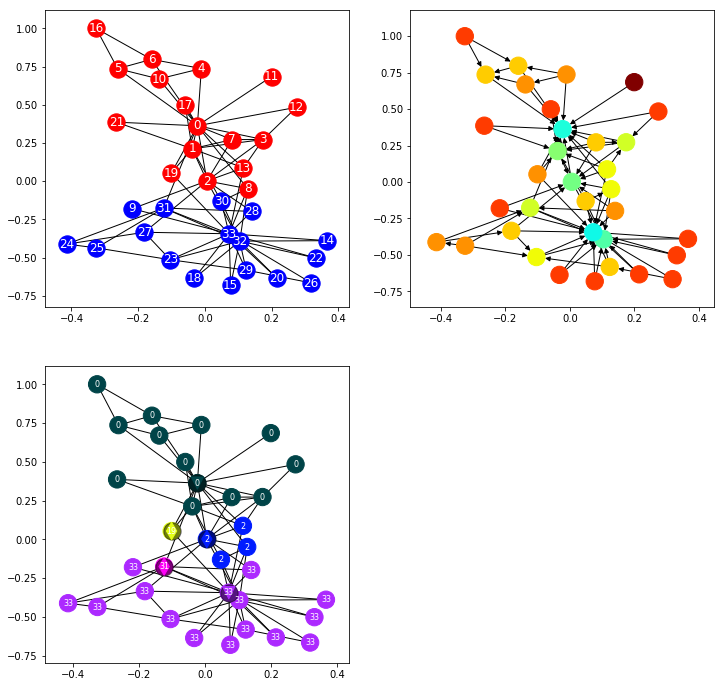

In [6]:


%matplotlib inline   
fig = matplotlib.pyplot.figure(figsize=(12,12))
ax_fast_alg = fig.add_subplot(2, 2, 3)
club_split = fig.add_subplot(2, 2, 1)
gradient = fig.add_subplot(2, 2, 2)

# draw results of algorithm
nx.draw_networkx_edges(G, pos=layout, ax=ax_fast_alg)
nx.draw_networkx_nodes(G, pos=layout, nodesize=[h(x)*300 for x in G.nodes()], node_color=[v for k,v in G.nodes.data('basin')], cmap='gist_ncar',vmin=-3, vmax=40, ax=ax_fast_alg)

nx.draw_networkx_nodes(G.subgraph(C[1]), pos=layout, nodesize=[h(x)*500 for x in G.subgraph(C[1]).nodes()], node_color='k', alpha=0.5, ax=ax_fast_alg)
nx.draw_networkx_nodes(G.subgraph(C[0]), pos=layout, nodesize=[h(x)*500 for x in G.subgraph(C[0]).nodes()], node_color='k', alpha=0.5, ax=ax_fast_alg)

nx.draw_networkx_nodes(G.subgraph(C[1]), pos=layout, node_size=150, node_color=[v for k,v in G.subgraph(C[1]).nodes.data('basin')], node_shape='d', cmap='gist_ncar',vmin=-3, vmax=40, ax=ax_fast_alg)
nx.draw_networkx_nodes(G.subgraph(C[0]), pos=layout, node_size=150, node_color=[v for k,v in G.subgraph(C[0]).nodes.data('basin')], node_shape='v', cmap='gist_ncar',vmin=-3, vmax=40, ax=ax_fast_alg)

nx.draw_networkx_labels(G, layout, labels=basin, font_size=8, font_color='w', ax=ax_fast_alg)

# draw club split
nx.draw_networkx_edges(G, pos=layout, ax=club_split)
club1 = [node for node in G if nx.get_node_attributes(G,"club")[node] == "Mr. Hi"]
club2 = [node for node in G if nx.get_node_attributes(G,"club")[node] == "Officer"]

nx.draw_networkx_nodes(G.subgraph(club1), pos=layout, nodesize=[h(x)*300 for x in G.nodes()], node_color='r', ax=club_split)
nx.draw_networkx_nodes(G.subgraph(club2), pos=layout, nodesize=[h(x)*300 for x in G.nodes()], node_color='b', ax=club_split)

nx.draw_networkx_labels(G, layout, font_size=12, font_color='w', ax=club_split)

# Draw gradient

G_directed = nx.DiGraph(G)
for u,v in G.edges:
    if h(u)<h(v):
        G_directed.remove_edge(u,v)
    else:
        G_directed.remove_edge(v,u)
G_directed.edges

nx.draw_networkx_edges(G_directed, pos=layout, ax=gradient)
nx.draw_networkx_nodes(G, pos=layout, nodesize=[h(x)*300 for x in G.nodes()], node_color=[h(v) for v in G.nodes], cmap='jet', vmin=-4.5, vmax=0, ax=gradient)

In [7]:
import dionysus as dn

In [60]:
import networkx.algorithms.dag as dag
import functools

def direct_G(G,h):
    G_directed = nx.DiGraph(G)
    for u,v in G.edges:
        if h(u)<h(v):
            G_directed.remove_edge(u,v)
        else:
            G_directed.remove_edge(v,u)
    return G_directed

class NetworkLandscape:
    def __init__(self, G, h):
        self.graph = G
        self.h = h
        self.directed = direct_G(self.graph, self.h)



def downhill_path(u,v,nl):
    '''returns True if there is a downhill path from u to v
    This does not count paths from one vertex to itself'''
    if nl.h(u) <=nl.h(v):
        return False
    else:
        if not dag.is_directed_acyclic_graph(nl.directed): 
            raise TypeError('NetworkLandscape.directed must be an acyclic directed graph')
        else: 
            return (u in dag.ancestors(nl.directed,v))
    
def nought_simplices(nl):
    return [dn.Simplex((node,), h(node)) for node in nl.graph.nodes()]

def one_simplices(nl):
    return [dn.Simplex((x,y), max(nl.h(x),nl.h(y))) for x in nl.graph.nodes() for y in nl.graph.nodes() if downhill_path(y,x, nl.directed, nl.h)]

def two_simplices(nl):
    return [dn.Simplex((x,y,z), max(h(x), h(y), h(z))) for x in nl.graph.nodes() for y in nl.graph.nodes() for z in nl.graph.nodes() if (downhill_path(y,x, nl) and downhill_path(z,y, nl))]

def graph_complex(G,h):
    return SimplicialComplex(two_simplices(G,h)+one_simplices(G,h)+nought_simplices(G,h))

def repeat(f,n):
    '''compose function f with itself n times'''
    def r(s):
        return functools.reduce(lambda x, _: f(x), range(n), s)
    return r

def discrete_gradient_flow(nl, k=1):
    '''This corresponds to D_{h,0}^k:2^V --> 2^V in the paper'''
    def dgf_0(x):
        if {y for y in nl.graph.neighbors(x) if h(y) < h(x)} :
            return {y for y in nl.graph.neighbors(x) if h(y) < h(x)} 
        else:
            return {x} 
    def dgf(vertex_set):
        if not vertex_set.issubset(set(nl.graph.nodes())):
            raise Error("input must be a subset of the nodes of graph")
        return functools.reduce(set.union,[dgf_0(x) for x in vertex_set])
    return repeat(dgf, k)

def inf_dgf(nl):
    '''At some point the sequence D^k(vertex_set), defined above, converges. This function limit'''
    def f(vertex_set):
        while discrete_gradient_flow(nl)(vertex_set) != vertex_set:
            vertex_set = discrete_gradient_flow(nl)(vertex_set)
        return vertex_set
    return f

def attraction_basin(x, nl, k):
    return {y for y in nl.graph.nodes() if inf_dgf(nl)({y}) == {x}}

In [62]:
nl = NetworkLandscape(G,h)
inf_dgf(nl)({1})
attraction_basin(0, nl, 1)

{0, 4, 5, 6, 10, 11, 16}

In [9]:
def filtration(G,h,k):
    B_k_minus_1 = union {attraction_basion(i, x)} for i in range(k) x in C[i]
    V_k = [x for x in G.nodes() if x not in B_k_minus_1]
    G_k = G.subgraph(V_k)
    return graph_complex(G_k, h)

In [10]:
f = dn.Filtration()
for s in cp:
    f.append(s)
f.sort()

In [15]:
m = dn.homology_persistence(f)

In [12]:
dgms = dn.init_diagrams(m, f)

In [13]:
for i, dgm in enumerate(dgms):
    print("Dimension:", i)
    print(dgm)

Dimension: 0
Diagram with 2 points
Dimension: 1
Diagram with 1 points
Dimension: 2
Diagram with 83 points
